# Recommendation System Tourism Place Collaborative Filtering

In [ ]:
! pip install surprise

!pip install folium # Map Plot
!pip install plotly # Interactive Plot

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 772.0/772.0 kB 11.1 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for scikit-surprise: filename=scikit_surprise-1.1.3-cp310-cp310-linux_x86_64.whl size=3095437 sha256=475affdf12b2d738020a5ee5d7f61e0856f4edc69efdfcc71cc5aab37e998a6a
  Stored in directory: /root/.cache/pip/wheels/a5/ca/a8/4e28def53797fdc4363ca4af740db15a9c2f1595ebc51fb445
Successfully built scikit-surprise
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
! pip list

Package                       Version
----------------------------- --------------------
absl-py                       1.4.0
alabaster                     0.7.13
albumentations                1.2.1
altair                        4.2.2
anyio                         3.6.2
appdirs                       1.4.4
argon2-cffi                   21.3.0
argon2-cffi-bindings          21.2.0
array-record                  0.2.0
arviz                         0.15.1
astropy                       5.2.2
astunparse                    1.6.3
attrs                         23.1.0
audioread                     3.0.0
autograd                      1.5
Babel                         2.12.1
backcall                      0.2.0
beautifulsoup4                4.11.2
bleach                        6.0.0
blis                          0.7.9
blosc2                        2.0.0
bokeh                         2.4.3
branca                        0.6.0
build                         0.10.0
CacheControl                  0.12.11
cac

In [ ]:
! python --version

Python 3.10.11


Library Import

In [ ]:
import pandas as pd
import numpy as np
import sklearn
import matplotlib.pyplot as plt
import seaborn as sns
import nltk
import surprise
import pickle
import plotly.express as px
import plotly.graph_objects as go
import plotly.figure_factory as ff
import time

from IPython import display
from surprise import SVDpp, Dataset, Reader, dump, NormalPredictor, BaselineOnly, KNNBasic, NMF, KNNWithMeans, KNNBaseline, SlopeOne, CoClustering, SVD
from surprise.accuracy import rmse, mae
from collections import defaultdict
from surprise.model_selection import cross_validate, GridSearchCV
from surprise import AlgoBase

%matplotlib inline

Set matplotlib figure format to SVG for high resolution image.

In [ ]:
from IPython import display
# display.set_matplotlib_formats("svg")

In [ ]:
from google.colab import files

print("Please upload your kaggle.json file.")
uploaded = files.upload()

for fn in uploaded.keys():
  print('User uploaded file "{name}" with length {length} bytes'.format(
      name=fn, length=len(uploaded[fn])))

Please upload your kaggle.json file.


Saving kaggle.json to kaggle.json
User uploaded file "kaggle.json" with length 71 bytes


In [ ]:
! cp ./kaggle.json ~/.kaggle/
! kaggle datasets download -d aprabowo/indonesia-tourism-destination
! unzip indonesia-tourism-destination.zip

  0% 0.00/158k [00:00<?, ?B/s]
100% 158k/158k [00:00<00:00, 68.8MB/s]
Archive:  indonesia-tourism-destination.zip
  inflating: package_tourism.csv     
  inflating: tourism_rating.csv      
  inflating: tourism_with_id.csv     
  inflating: user.csv                


## Data Loading

Load Tourism with ID rating.

In [ ]:
tourism_dataset_path = f"tourism_with_id.csv"
data_df = pd.read_csv(tourism_dataset_path)

data_df = data_df.drop(["Unnamed: 11", "Unnamed: 12"], axis = 1)
data_df.head(5)

,Place_Id,Place_Name,Description,Category,City,Price,Rating,Time_Minutes,Coordinate,Lat,Long
0,1,Monumen Nasional,Monumen Nasional atau yang populer disingkat d...,Budaya,Jakarta,20000,4.6,15.0,"{'lat': -6.1753924, 'lng': 106.8271528}",-6.175392,106.827153
1,2,Kota Tua,"Kota tua di Jakarta, yang juga bernama Kota Tu...",Budaya,Jakarta,0,4.6,90.0,"{'lat': -6.137644799999999, 'lng': 106.8171245}",-6.137645,106.817125
2,3,Dunia Fantasi,Dunia Fantasi atau disebut juga Dufan adalah t...,Taman Hiburan,Jakarta,270000,4.6,360.0,"{'lat': -6.125312399999999, 'lng': 106.8335377}",-6.125312,106.833538
3,4,Taman Mini Indonesia Indah (TMII),Taman Mini Indonesia Indah merupakan suatu kaw...,Taman Hiburan,Jakarta,10000,4.5,NaN,"{'lat': -6.302445899999999, 'lng': 106.8951559}",-6.302446,106.895156
4,5,Atlantis Water Adventure,Atlantis Water Adventure atau dikenal dengan A...,Taman Hiburan,Jakarta,94000,4.5,60.0,"{'lat': -6.12419, 'lng': 106.839134}",-6.124190,106.839134


In [ ]:
data_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 437 entries, 0 to 436
Data columns (total 11 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   Place_Id      437 non-null    int64  
 1   Place_Name    437 non-null    object 
 2   Description   437 non-null    object 
 3   Category      437 non-null    object 
 4   City          437 non-null    object 
 5   Price         437 non-null    int64  
 6   Rating        437 non-null    float64
 7   Time_Minutes  205 non-null    float64
 8   Coordinate    437 non-null    object 
 9   Lat           437 non-null    float64
 10  Long          437 non-null    float64
dtypes: float64(4), int64(2), object(5)
memory usage: 37.7+ KB


In [ ]:
dataset_path = f"tourism_rating.csv"
rating_data_df = pd.read_csv(dataset_path, delimiter = ',')

rating_data_df.head(5)

,User_Id,Place_Id,Place_Ratings
0,1,179,3
1,1,344,2
2,1,5,5
3,1,373,3
4,1,101,4


In [ ]:
rating_data_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 3 columns):
 #   Column         Non-Null Count  Dtype
---  ------         --------------  -----
 0   User_Id        10000 non-null  int64
 1   Place_Id       10000 non-null  int64
 2   Place_Ratings  10000 non-null  int64
dtypes: int64(3)
memory usage: 234.5 KB


## Data Preprocessing

Remove Coordinate Rating, since Lat and Long column already serve the same purpose.

In [ ]:
preprocessed_data_df = data_df.copy()
# preprocessed_data_df = preprocessed_data_df.drop("Coordinate", axis = 1)
preprocessed_data_df.columns

Index(['Place_Id', 'Place_Name', 'Description', 'Category', 'City', 'Price',
       'Rating', 'Time_Minutes', 'Coordinate', 'Lat', 'Long'],
      dtype='object')

In [ ]:
# preprocessed_data_df = data_df.copy()
# preprocessed_data_df["Lat"] = preprocessed_data_df["Lat"].replace(",", ".", regex = True)
# preprocessed_data_df["Long"] = preprocessed_data_df["Long"].replace(",", ".", regex = True)

# preprocessed_data_df["Lat"] = preprocessed_data_df["Lat"].astype("float")
# preprocessed_data_df["Long"] = preprocessed_data_df["Long"].astype("float")

preprocessed_data_df.head(2)

,Place_Id,Place_Name,Description,Category,City,Price,Rating,Time_Minutes,Coordinate,Lat,Long
0,1,Monumen Nasional,Monumen Nasional atau yang populer disingkat d...,Budaya,Jakarta,20000,4.6,15.0,"{'lat': -6.1753924, 'lng': 106.8271528}",-6.175392,106.827153
1,2,Kota Tua,"Kota tua di Jakarta, yang juga bernama Kota Tu...",Budaya,Jakarta,0,4.6,90.0,"{'lat': -6.137644799999999, 'lng': 106.8171245}",-6.137645,106.817125


In [ ]:
preprocessed_data_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 437 entries, 0 to 436
Data columns (total 11 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   Place_Id      437 non-null    int64  
 1   Place_Name    437 non-null    object 
 2   Description   437 non-null    object 
 3   Category      437 non-null    object 
 4   City          437 non-null    object 
 5   Price         437 non-null    int64  
 6   Rating        437 non-null    float64
 7   Time_Minutes  205 non-null    float64
 8   Coordinate    437 non-null    object 
 9   Lat           437 non-null    float64
 10  Long          437 non-null    float64
dtypes: float64(4), int64(2), object(5)
memory usage: 37.7+ KB


Define Dataset Variables

In [ ]:
user_id_field = "User_Id"
place_id_field = "Place_Id"
place_ratings_field = "Place_Ratings"

## Data Visualization

### Tourism Place Analysis

Category Analysis

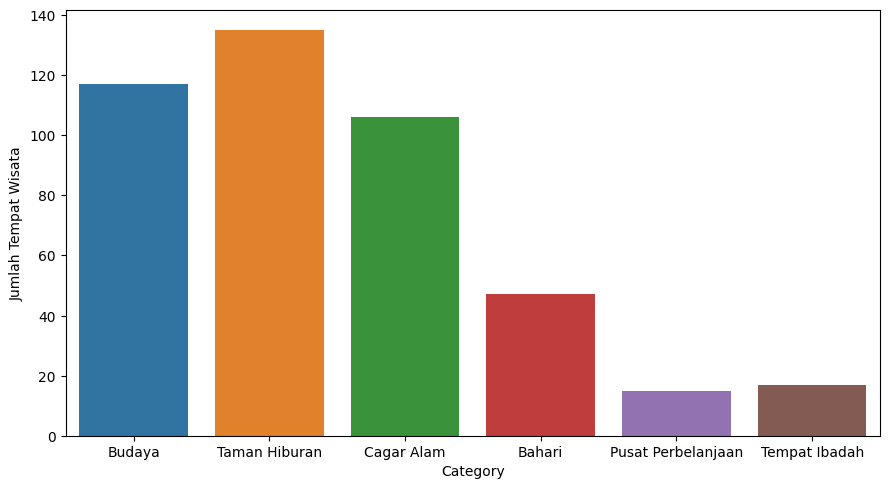

In [ ]:
plt.figure(figsize = (9, 5))

sns.countplot(data = preprocessed_data_df, x = "Category")
plt.ylabel("Jumlah Tempat Wisata")
plt.tight_layout()
plt.savefig('Category.png')
plt.show()

City Analysis

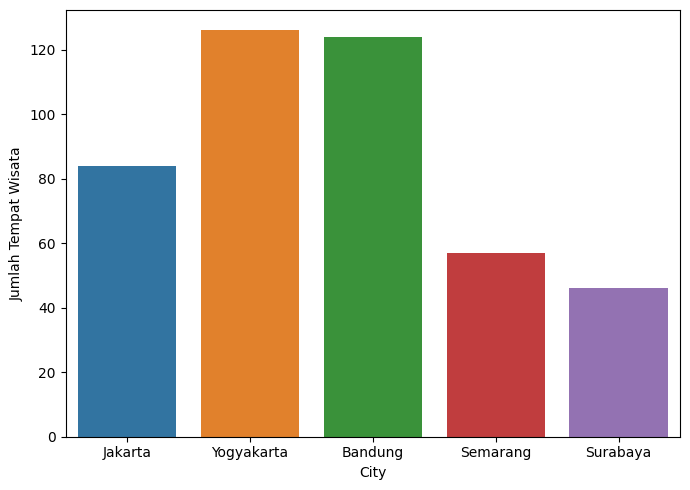

In [ ]:
plt.figure(figsize = (7, 5))

sns.countplot(data = preprocessed_data_df, x = "City")
plt.ylabel("Jumlah Tempat Wisata")
plt.tight_layout()
plt.savefig('City.png')
plt.show()

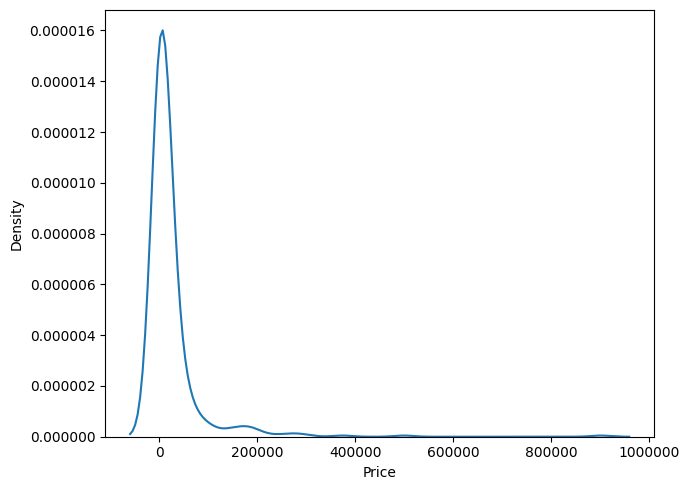

In [ ]:
plt.figure(figsize = (7, 5))

sns.kdeplot(data = preprocessed_data_df, x = "Price")
plt.ticklabel_format(useOffset = False, style='plain')
plt.savefig('Price.png')
plt.tight_layout()
plt.show()

Geolocation Analysis for travelling places.

In [ ]:
fig = px.density_mapbox(
  preprocessed_data_df, lat = 'Lat',
  lon = 'Long', hover_name = 'Place_Name',
  radius = 5,
  zoom = 0, height = 700
)
fig.update_layout(title = "Analisis Lokasi Tempat Wisata")
fig.update_layout(mapbox_style = 'open-street-map', mapbox_center_lon = 0)

fig.show()

Check tourism place of Pelabuhan Marina

In [ ]:
preprocessed_data_df[preprocessed_data_df["Place_Name"] == "Pelabuhan Marina"]

,Place_Id,Place_Name,Description,Category,City,Price,Rating,Time_Minutes,Coordinate,Lat,Long
8,9,Pelabuhan Marina,Pelabuhan Marina Ancol berada di kawasan Taman...,Bahari,Jakarta,175000,4.4,NaN,"{'lat': 1.07888, 'lng': 103.931398}",1.07888,103.931398


### Tourism Rating Analysis

See Number of Ratings given

In [ ]:
len(rating_data_df)

10000

See rating data statistics

In [ ]:
user_id_counts = rating_data_df[user_id_field].value_counts()
user_id_counts.describe()

count    300.000000
mean      33.333333
std        5.585656
min       21.000000
25%       29.000000
50%       33.000000
75%       37.000000
max       53.000000
Name: User_Id, dtype: float64

Check how many ratings are there from 1 to 5.

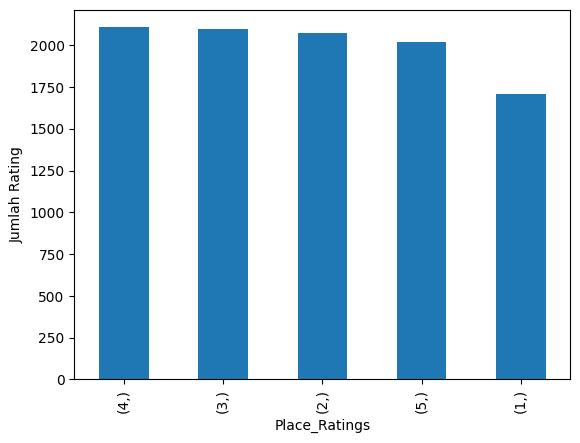

In [ ]:
unique_values_rating_data_count = rating_data_df[[place_ratings_field]].value_counts()
unique_values_rating_data_count.plot(kind = 'bar')
plt.ylabel("Jumlah Rating")
plt.savefig("Rating.png")

See average rating for each tourism place.

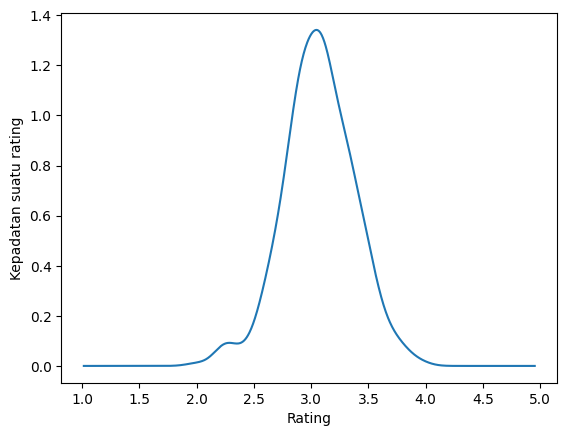

In [ ]:
rating_and_tourism_merged_df = pd.merge(preprocessed_data_df, rating_data_df, how = 'inner', on = 'Place_Id')
rating_and_tourism_grouped_by_df = rating_and_tourism_merged_df.groupby("Place_Id")["Place_Ratings"]
rating_and_tourism_grouped_by_df.mean().plot(kind = 'kde')

plt.xlabel("Rating")
plt.ylabel("Kepadatan suatu rating")
plt.savefig("Rating.png")

See number of ratings for each tourism place.

<Axes: ylabel='Density'>

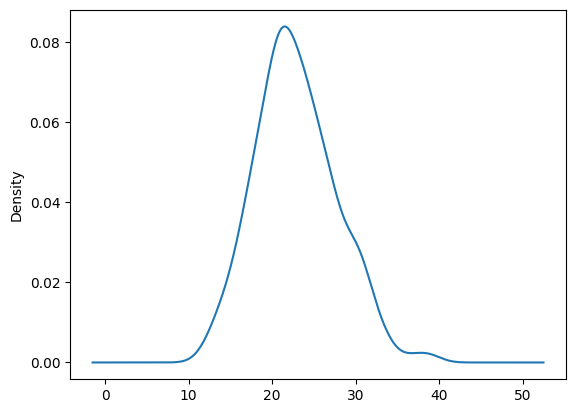

In [ ]:
rating_and_tourism_merged_df = pd.merge(preprocessed_data_df, rating_data_df, how = 'inner', on = 'Place_Id')
rating_and_tourism_grouped_by_df = rating_and_tourism_merged_df.groupby("Place_Id")["Place_Ratings"]
rating_and_tourism_grouped_by_df.count().plot(kind = 'kde')

See tourism place rating distribution based on each city.

In [ ]:
rating_and_tourism_merged_df = pd.merge(preprocessed_data_df, rating_data_df, how = 'inner', on = 'Place_Id')
rating_and_tourism_grouped_by_df = rating_and_tourism_merged_df.groupby("City")["Place_Ratings"]
rating_and_tourism_grouped_by_df.mean()

City
Bandung       3.078466
Jakarta       3.010937
Semarang      3.034169
Surabaya      3.072381
Yogyakarta    3.104493
Name: Place_Ratings, dtype: float64

## Data Preparation

In [ ]:
preprocessed_data_df.columns

Index(['Place_Id', 'Place_Name', 'Description', 'Category', 'City', 'Price',
       'Rating', 'Time_Minutes', 'Coordinate', 'Lat', 'Long'],
      dtype='object')

Delete unnecessary columns.

In [ ]:
preprocessed_data_df = preprocessed_data_df.drop(["Time_Minutes", "Coordinate"], axis = 1)
preprocessed_data_df

,Place_Id,Place_Name,Description,Category,City,Price,Rating,Lat,Long
0,1,Monumen Nasional,Monumen Nasional atau yang populer disingkat d...,Budaya,Jakarta,20000,4.6,-6.175392,106.827153
1,2,Kota Tua,"Kota tua di Jakarta, yang juga bernama Kota Tu...",Budaya,Jakarta,0,4.6,-6.137645,106.817125
2,3,Dunia Fantasi,Dunia Fantasi atau disebut juga Dufan adalah t...,Taman Hiburan,Jakarta,270000,4.6,-6.125312,106.833538
3,4,Taman Mini Indonesia Indah (TMII),Taman Mini Indonesia Indah merupakan suatu kaw...,Taman Hiburan,Jakarta,10000,4.5,-6.302446,106.895156
4,5,Atlantis Water Adventure,Atlantis Water Adventure atau dikenal dengan A...,Taman Hiburan,Jakarta,94000,4.5,-6.124190,106.839134
...,...,...,...,...,...,...,...,...,...
432,433,Museum Mpu Tantular,Museum Negeri Mpu Tantular adalah sebuah museu...,Budaya,Surabaya,2000,4.4,-7.433859,112.719906
433,434,Taman Bungkul,Taman Bungkul adalah taman wisata kota yang te...,Taman Hiburan,Surabaya,0,4.6,-7.291347,112.739822
434,435,Taman Air Mancur Menari Kenjeran,Air mancur menari atau dancing fountain juga a...,Taman Hiburan,Surabaya,0,4.4,-7.275296,112.754938
435,436,Taman Flora Bratang Surabaya,Taman Flora adalah salah satu taman kota di Su...,Taman Hiburan,Surabaya,0,4.6,-7.294330,112.761753


Change Pelabuhan Marina Latitude and Longitude.

In [ ]:
preprocessed_data_df.loc[8, ['Lat', 'Long']] = [-6.11875169705, 106.828984697]
preprocessed_data_df.loc[8]

Place_Id                                                       9
Place_Name                                      Pelabuhan Marina
Description    Pelabuhan Marina Ancol berada di kawasan Taman...
Category                                                  Bahari
City                                                     Jakarta
Price                                                     175000
Rating                                                       4.4
Lat                                                    -6.118752
Long                                                  106.828985
Name: 8, dtype: object

In [ ]:
rating_data_preprocessed_df = rating_data_df.copy()
rating_data_preprocessed_df.describe()["Place_Ratings"]

count    10000.000000
mean         3.066500
std          1.379952
min          1.000000
25%          2.000000
50%          3.000000
75%          4.000000
max          5.000000
Name: Place_Ratings, dtype: float64

Save the dataset.

In [ ]:
preprocessed_data_df.to_csv("preprocessed_indonesia_tourism_destination_df.csv", index = False)

## Data Modelling

In [ ]:
rating_data_preprocessed_df

,User_Id,Place_Id,Place_Ratings
0,1,179,3
1,1,344,2
2,1,5,5
3,1,373,3
4,1,101,4
...,...,...,...
9995,300,425,2
9996,300,64,4
9997,300,311,3
9998,300,279,4


Get Sample Data Test Case with lowest rating count

In [ ]:
user_id_counts = rating_data_preprocessed_df[user_id_field].value_counts()
minimum_user_id_rating_counts = user_id_counts[user_id_counts == 21]
minimum_user_id_rating_counts

60    21
Name: User_Id, dtype: int64

In [ ]:
sample_test_case_user_id = np.array(minimum_user_id_rating_counts.index)[0]
print(sample_test_case_user_id)

60


In [ ]:
sample_user_data_df = rating_data_preprocessed_df[rating_data_preprocessed_df["User_Id"] == sample_test_case_user_id]
sample_user_data_df

,User_Id,Place_Id,Place_Ratings
1941,60,50,4
1942,60,337,1
1943,60,234,3
1944,60,131,4
1945,60,236,4
1946,60,129,2
1947,60,296,2
1948,60,271,4
1949,60,150,1
1950,60,181,3


See the description of the travelling place the user has rated.

In [ ]:
data_df[place_id_field] = data_df[place_id_field].astype(int)

visualized_rating_df = sample_user_data_df.merge(
    data_df,
    left_on = place_id_field,
    right_on = place_id_field,

)

visualized_rating_df

,User_Id,Place_Id,Place_Ratings,Place_Name,Description,Category,City,Price,Rating,Time_Minutes,Coordinate,Lat,Long
0,60,50,4,Museum Joang 45,Gedung Joang '45 atau Museum Joang 45 adalah s...,Budaya,Jakarta,2000,4.0,NaN,"{'lat': -6.186183799999998, 'lng': 106.8364761}",-6.186184,106.836476
1,60,337,1,Kampung Pelangi,Kampung pelangi atau dalam bahasa Inggris dise...,Taman Hiburan,Semarang,3000,4.3,30.0,"{'lat': -6.988881200000001, 'lng': 110.4083781}",-6.988881,110.408378
2,60,234,3,Amazing Art World,"Amazing Art World Bandung, sebuah objek wisata...",Budaya,Bandung,75000,4.5,45.0,"{'lat': -6.8516591, 'lng': 107.5955534}",-6.851659,107.595553
3,60,131,4,Watu Lumbung,Letak Kampung Edukasi Watu Lumbung yang berada...,Cagar Alam,Yogyakarta,5000,4.3,30.0,"{'lat': -7.992437900000001, 'lng': 110.317778}",-7.992438,110.317778
4,60,236,4,Taman Balai Kota Bandung,Taman Balai Kota Bandung merupakan sebuah tama...,Taman Hiburan,Bandung,0,4.6,45.0,"{'lat': -6.912966000000001, 'lng': 107.6096031}",-6.912966,107.609603
5,60,129,2,Bukit Lintang Sewu,Bukit Lintang Sewu ini berasal ketika pada saa...,Taman Hiburan,Yogyakarta,2000,4.5,60.0,"{'lat': -7.915799699999999, 'lng': 110.4366436}",-7.915800,110.436644
6,60,296,2,Batununggal Indah Club,Kolam renang Batununggal merupakan salah satu ...,Taman Hiburan,Bandung,70000,4.4,NaN,"{'lat': -6.963229999999999, 'lng': 107.626416}",-6.963230,107.626416
7,60,271,4,Taman Vanda,Taman Vanda Bandung adalah taman yang terletak...,Taman Hiburan,Bandung,0,4.3,45.0,"{'lat': -6.9140478, 'lng': 107.6101684}",-6.914048,107.610168
8,60,150,1,Wisata Kraton Jogja,Kraton Jogja adalah sebuah komplek kerajaan ya...,Budaya,Yogyakarta,7000,4.7,NaN,"{'lat': -7.806753499999999, 'lng': 110.3636659}",-7.806754,110.363666
9,60,181,3,Pantai Sundak,Pantai Sundak merupakan salah satu pantai inda...,Bahari,Yogyakarta,5000,4.5,NaN,"{'lat': -8.147072, 'lng': 110.6079043}",-8.147072,110.607904


Load Rating Dataset using Surprise Library

In [ ]:
def load_rating_df_with_surprise(rating_data_df, rating_scale = (1, 5)):
  reader = Reader(rating_scale = rating_scale)
  rating_surprise_data = Dataset.load_from_df(rating_data_df, reader = reader)
  return rating_surprise_data

rating_surprise_data = load_rating_df_with_surprise(rating_data_preprocessed_df)

Perform Grid Search on Rating Dataset

In [ ]:
def perform_grid_search(data, model, model_name, model_parameters, n_splits = 10):
  print("=================================")
  print(f"{model_name} Grid Search Result:")
  grid_search_cv = GridSearchCV(
      model,
      param_grid = model_parameters,
      cv = n_splits,
      n_jobs = -1,
      measures = ['rmse', 'mae']
  )
  grid_search_cv.fit(data)
  print(grid_search_cv.best_params)
  print("=================================")
  return grid_search_cv.best_params, grid_search_cv.cv_results

svdpp_parameters = {
    # "n_epochs": np.linspace(1, 5, 5).astype(int),
    "n_epochs": [3, 4, 5],
    # "lr_all": np.linspace(0.001, 0.01, 10),
    "lr_all": [0.001, 0.003, 0.005],
    # "lr_all": [0.003],
    "reg_all": [0.09, 0.1, 0.11],
    # "reg_all": [0.1],
    "random_state": [200],
}

# regular_svd_parameters = {
#     # "n_epochs": np.linspace(20, 25, 5).astype(int),
#     "n_epochs": [3],
#     # "lr_all": np.linspace(0.001, 0.01, 10),
#      "lr_all": [0.003],
#     # "reg_all": np.linspace(0.01, 0.1, 10),
#     "reg_all": [0.1],
#     "init_mean": np.linspace(0, 0.5, 10),
#     # "init_mean": [0],
#     "init_std_dev": np.linspace(0, 0.5, 5),
#     "random_state": [200],
# }

svdpp_best_params, cv_result = perform_grid_search(rating_surprise_data, SVDpp, "SVD++", svdpp_parameters)

SVD++ Grid Search Result:
{'rmse': {'n_epochs': 3, 'lr_all': 0.003, 'reg_all': 0.11, 'random_state': 200}, 'mae': {'n_epochs': 3, 'lr_all': 0.001, 'reg_all': 0.11, 'random_state': 200}}


In [ ]:
print(pd.DataFrame.from_dict(cv_result).columns)
result_df = pd.DataFrame.from_dict(cv_result)[["param_n_epochs", "param_lr_all", "param_reg_all", "mean_test_rmse", "mean_test_mae"]]
result_df.to_csv("result_svd++.csv", sep = ';', decimal=',', index = False)

Index(['split0_test_rmse', 'split1_test_rmse', 'split2_test_rmse',
       'split3_test_rmse', 'split4_test_rmse', 'split5_test_rmse',
       'split6_test_rmse', 'split7_test_rmse', 'split8_test_rmse',
       'split9_test_rmse', 'mean_test_rmse', 'std_test_rmse', 'rank_test_rmse',
       'split0_test_mae', 'split1_test_mae', 'split2_test_mae',
       'split3_test_mae', 'split4_test_mae', 'split5_test_mae',
       'split6_test_mae', 'split7_test_mae', 'split8_test_mae',
       'split9_test_mae', 'mean_test_mae', 'std_test_mae', 'rank_test_mae',
       'mean_fit_time', 'std_fit_time', 'mean_test_time', 'std_test_time',
       'params', 'param_n_epochs', 'param_lr_all', 'param_reg_all',
       'param_random_state'],
      dtype='object')


In [ ]:
my_svdpp_best_params = svdpp_best_params['mae']
# my_svd_best_params = svd_best_params['mae']

Perform K Fold Cross Validation on Rating Dataset

In [ ]:
np.random.seed(101)

def load_surpise_dataset(rating_surprise_data):
  full_trainset = rating_surprise_data.build_full_trainset()
  full_anti_testset = full_trainset.build_anti_testset()
  full_testset = full_trainset.build_testset()
  return full_trainset, full_anti_testset, full_testset

def perform_cross_validate(classifier, train_data_df, cv = 10):
  cross_validate(classifier,
                train_data_df,
                measures = ['RMSE', 'MAE'],
                cv = cv,
                verbose = True)

print("SVD++ K Fold Cross Validation Result:")
perform_cross_validate(SVDpp(**my_svdpp_best_params), rating_surprise_data)

# print("SVD K Fold Cross Validation Result:")
# perform_cross_validate(SVD(**my_svd_best_params), rating_surprise_data)

print("NormalPredictor K Fold Cross Validation Result:")
perform_cross_validate(NormalPredictor(), rating_surprise_data)

SVD++ K Fold Cross Validation Result:
Evaluating RMSE, MAE of algorithm SVDpp on 10 split(s).

                  Fold 1  Fold 2  Fold 3  Fold 4  Fold 5  Fold 6  Fold 7  Fold 8  Fold 9  Fold 10 Mean    Std     
RMSE (testset)    1.3564  1.3794  1.4054  1.3612  1.3660  1.3873  1.3756  1.3984  1.3892  1.3790  1.3798  0.0150  
MAE (testset)     1.1511  1.1661  1.2094  1.1607  1.1453  1.1989  1.1681  1.1947  1.1880  1.1771  1.1759  0.0202  
Fit time          0.16    0.17    0.16    0.16    0.15    0.15    0.08    0.09    0.08    0.09    0.13    0.03    
Test time         0.09    0.10    0.09    0.09    0.09    0.06    0.04    0.04    0.06    0.05    0.07    0.02    
NormalPredictor K Fold Cross Validation Result:
Evaluating RMSE, MAE of algorithm NormalPredictor on 10 split(s).

                  Fold 1  Fold 2  Fold 3  Fold 4  Fold 5  Fold 6  Fold 7  Fold 8  Fold 9  Fold 10 Mean    Std     
RMSE (testset)    1.8140  1.8188  1.8425  1.8798  1.8369  1.8002  1.8365  1.8870  1.7774  1.8174  1.

Compare with Baseline Parameters from Surprise Library

In [ ]:
np.random.seed(101)

print("SVDpp K Fold Cross Validation Result:")
perform_cross_validate(SVDpp(random_state = 200), rating_surprise_data)

print("SVD K Fold Cross Validation Result:")
perform_cross_validate(SVD(random_state = 200), rating_surprise_data)

print("NormalPredictor K Fold Cross Validation Result:")
perform_cross_validate(NormalPredictor(), rating_surprise_data)

SVDpp K Fold Cross Validation Result:
Evaluating RMSE, MAE of algorithm SVDpp on 10 split(s).

                  Fold 1  Fold 2  Fold 3  Fold 4  Fold 5  Fold 6  Fold 7  Fold 8  Fold 9  Fold 10 Mean    Std     
RMSE (testset)    1.3875  1.4202  1.4527  1.4173  1.4378  1.4484  1.4120  1.4483  1.4615  1.4519  1.4337  0.0223  
MAE (testset)     1.1830  1.2105  1.2465  1.2172  1.2253  1.2479  1.2018  1.2479  1.2530  1.2379  1.2271  0.0223  
Fit time          0.57    0.56    0.55    0.55    0.55    0.54    0.57    0.54    0.54    0.69    0.56    0.04    
Test time         0.04    0.04    0.05    0.04    0.08    0.04    0.07    0.08    0.04    0.09    0.06    0.02    
SVD K Fold Cross Validation Result:
Evaluating RMSE, MAE of algorithm SVD on 10 split(s).

                  Fold 1  Fold 2  Fold 3  Fold 4  Fold 5  Fold 6  Fold 7  Fold 8  Fold 9  Fold 10 Mean    Std     
RMSE (testset)    1.4138  1.4063  1.4089  1.4477  1.4308  1.4172  1.3939  1.4077  1.4128  1.4190  1.4158  0.0140  
MAE (test

NameError: ignored